# Engagement outcomes

For the primary and some secondary outcomes, we need to use Google Analytics page views data:

**Primary outcome: Difference in the proportion of practices having their dashboard viewed during the 15 week intervention period, between intervention and control groups.** 

**Secondary: Change in practice dashboard views for all practices**
*This will be used to assess the global impact of the interventions, including access by non-intervention practices as a result of contamination and increased general awareness. This will be measured as change from baseline (15 weeks prior to first intervention) in the number of practices having their dashboard accessed, as a proportion of all practices, during the 15 week intervention period.*

## Analytics data extraction procedure:

 `Analytics - Behaviour - Site Content - All Pages`
 
 (this allows us to exclude specific measures accessed for individual practices, which may have been accessed from CCG pages)

 ```
 SEARCH: "/practice"
 DATE RANGE: 15 weeks from the date of WAVE1 (including date sent) and 15 weeks prior (2 separate downloads).
 SHOW ROWS: 5000
 ```
 
 Export as CSV

 Before importing, tidy up the csv to create a flat table
 (remove top and bottom groups of rows, convert numerical data to general format to remove commas)
 
### Time periods
 Start date: '2018-05-07' (note this is a BH so effectively next day is start)
 
- 5 weeks prior: '2018-04-02' - '2018-05-06'
- 15 weeks prior: '2018-01-22' - '2018-05-06' 
- wave 1: '2018-05-07' - '2018-06-10'
- wave 2: '2018-06-11' - '2018-07-15'
- wave 3: '2018-07-16' - '2018-08-19'

In [1]:
# Import page views data
import pandas as pd
import numpy as np
dfb = pd.read_csv('pageviews_20170313_20170625.csv',usecols={"Page","Pageviews","Unique Pageviews"} ) # before
dfa = pd.read_csv('pageviews_20170626_20171008.csv',usecols={"Page","Pageviews","Unique Pageviews"}, dtype={'Pageviews': np.int32}) # after

### Narrow down to practice dashboards only and extract practice code

# baseline data
dfb = dfb.rename(columns={'Page': 'practice_id'}) 
dfb = dfb.loc[dfb['practice_id'] != '/']          #remove any instances of root practice page
dfb = dfb.loc[dfb['practice_id'].str.len() == 17 ]  #limit to paths of at least 17 characters to exclude erroneous (too short) practice codes

# folllow-up data
dfa = dfa.rename(columns={'Page': 'practice_id'})
dfa = dfa.loc[dfa['practice_id'] != '/']
dfa = dfa.loc[dfa['practice_id'].str.len() == 17]

# extract practice code from path
dfb.practice_id = dfb.practice_id.str.replace('/practice', '')
dfa.practice_id = dfa.practice_id.str.replace('/practice', '')
dfb.practice_id = dfb.practice_id.str.replace('/', '')
dfa.practice_id = dfa.practice_id.str.replace('/', '')

dfa.sort_values(by="Unique Pageviews").reset_index(drop=True).head()

,practice_id,Pageviews,Unique Pageviews
0,Y00711,2,1
1,F81697,1,1
2,F81690,1,1
3,F81683,1,1
4,F81679,1,1


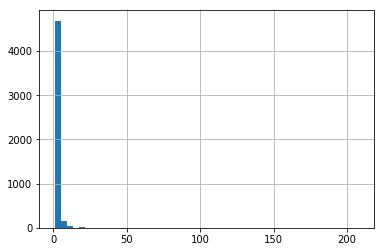

,Pageviews,Unique Pageviews
count,4909.000000,4909.000000
mean,2.598085,2.126910
std,4.468536,3.555416
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,243.000000,208.000000


In [2]:
import matplotlib.pyplot as plt

dfa['Unique Pageviews'].hist(bins=50)
plt.show()
dfa.describe()

### import allocated practices dataset and join to page views data

In [3]:
prac = pd.read_csv('allocated_practices_cephalosporin_test2.csv')

b = dfb
a = dfa

m = prac.merge(b, how='left', on='practice_id')
m2 = m.merge(a, how='left', on='practice_id',suffixes={"_before","_after"})
m2.allocation = m2.allocation.fillna('con') # replace NaNs in order to perform groupby on this field
m2['Unique Pageviews_before'] = m2['Unique Pageviews_before'].fillna(0)
m2['Unique Pageviews_after'] = m2['Unique Pageviews_after'].fillna(0)
m2.describe()

,Unnamed: 0,baseline,baseline_ranking,Pageviews_before,Unique Pageviews_before,Pageviews_after,Unique Pageviews_after
count,1405.000000,1405.000000,1405.000000,709.000000,1405.000000,765.000000,1405.000000
mean,702.000000,0.127296,0.900026,2.349788,0.967972,2.614379,1.166548
std,405.732876,0.023416,0.057781,2.705209,1.648093,2.596121,1.708665
min,0.000000,0.105100,0.800057,1.000000,0.000000,1.000000,0.000000
25%,351.000000,0.111362,0.850043,1.000000,0.000000,1.000000,0.000000
50%,702.000000,0.120357,0.900028,2.000000,1.000000,2.000000,1.000000
75%,1053.000000,0.134597,0.950014,3.000000,1.000000,3.000000,2.000000
max,1404.000000,0.323985,1.000000,35.000000,25.000000,24.000000,19.000000


### max-out top 1%

In [4]:

max_out = m2['Unique Pageviews_before'].quantile(0.99)
m2["proxy_pageviews_before"] = np.where(m2['Unique Pageviews_before']<max_out, m2['Unique Pageviews_before'], max_out)

max_out_b = m2['Unique Pageviews_after'].quantile(0.99)
m2["proxy_pageviews_after"] = np.where(m2['Unique Pageviews_after']<max_out_b, m2['Unique Pageviews_after'], max_out_b)

#m2["morethan1_pageviews_before"] = np.where(m2['Unique Pageviews_before']>1, 1,0)
#m2["morethan1_pageviews_after"] = np.where(m2['Unique Pageviews_after']>1, 1,0)

result = pd.DataFrame({'Unique Pageviews_after': m2["Unique Pageviews_after"].describe(),
                       'Unique Pageviews_before': m2["Unique Pageviews_before"].describe(),
                       'Proxy_pageviews_after': m2["proxy_pageviews_after"].describe(),
                       'Proxy_pageviews_before': m2["proxy_pageviews_before"].describe()
                      })

result


,Proxy_pageviews_after,Proxy_pageviews_before,Unique Pageviews_after,Unique Pageviews_before
count,1405.000000,1405.000000,1405.000000,1405.000000
mean,1.126690,0.923132,1.166548,0.967972
std,1.488189,1.300805,1.708665,1.648093
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,2.000000,1.000000,2.000000,1.000000
max,7.000000,7.000000,19.000000,25.000000


# Primary engagement outcome #######################################################
## Difference in the proportion of practices having their dashboard viewed during the 15 week intervention period, between intervention and control groups. 


In [5]:

# define aggregations
aggregations = {
    'practice_id': { # work on the "practice_id" column
        'Count': 'count'},
    'Pageviews_before': {     
        'Distinct pages': 'count'},
    'Pageviews_after': {     
        'Distinct pages': 'count'},
    'proxy_pageviews_before': {
        'Mean': 'mean',
        'StDev': 'std',
        'Max': 'max',
        'Median': 'median'},
    'proxy_pageviews_after': {
        'Mean': 'mean',
        'StDev': 'std',
        'Max': 'max',
        'Median': 'median'}
}

# Perform groupby aggregation for intervention vs control
m3 = m2.reset_index()
m3 = m3.groupby(["allocation"]).agg(aggregations)

m3 = m3.rename(columns={'proxy_pageviews_before': 'Page Views per Page (Before)', 'Pageviews_after':'Pages viewed After','Pageviews_before':'Pages viewed Before','proxy_pageviews_after': 'Page Views per Page (After)','practice_id':'Practices'}) 
m3["Pages viewed Before","%"] = m3['Pages viewed Before','Distinct pages']/m3['Practices','Count']
m3["Pages viewed After","%"] = m3['Pages viewed After','Distinct pages']/m3['Practices','Count']
m3 = m3.sort_index(axis=1)

m4 = m3[['Practices','Pages viewed Before','Pages viewed After']].sort_index(ascending=False)
#m3["change from baseline"] = m3["follow-up"]["percent_viewed_follow-up"] - m3["baseline"]["percent_viewed_baseline"]


m4

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Practices Pages viewed Before                Pages viewed After  \
               Count                   % Distinct pages                  %   
allocation                                                                   
con              705            0.499291            352           0.544681   
I                700            0.510000            357           0.544286   

                           
           Distinct pages  
allocation                 
con                   384  
I                     381

### Statistical analysis

In [6]:
# Primary and secondary outcomes measured as proportions will be compared with confidence intervals (CIs) and chi-squared tests
from scipy.stats import chi2_contingency

s1 = pd.DataFrame(m4.iloc[:,[0,4]]).reset_index()
s1.columns = s1.columns.droplevel()
s1["Not viewed"] = s1["Count"]-s1["Distinct pages"]
obs = np.array(s1[["Distinct pages","Not viewed"]])
 
print(s1)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

def diffprop(obs):
    """
    `obs` must be a 2x2 numpy array.

    Returns:
    delta
        The difference in proportions
    ci
        The Wald 95% confidence interval for delta
    corrected_ci
        Yates continuity correction for the 95% confidence interval of delta.
    """
    n1, n2 = obs.sum(axis=1)
    prop1 = obs[0,0] / n1
    prop2 = obs[1,0] / n2
    delta = prop1 - prop2

    # Wald 95% confidence interval for delta
    se = np.sqrt(prop1*(1 - prop1)/n1 + prop2*(1 - prop2)/n2)
    ci = (delta - 1.96*se, delta + 1.96*se)

    # Yates continuity correction for confidence interval of delta
    correction = 0.5*(1/n1 + 1/n2)
    corrected_ci = (ci[0] - correction, ci[1] + correction)

    return delta, ci, corrected_ci

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d, 'confidence intervals: ',ci1)


        Count  Distinct pages  Not viewed
0  con    705             384         321
1    I    700             381         319
chi2 =  0.00149768283126 ; p =  0.969129647255
difference in proportion:  0.000395136778116 confidence intervals:  (-0.051687757550219073, 0.052478031106450142)


# Secondary outcomes

## The primary outcome will also be compared between groups A and B.

In [7]:

# Perform groupby aggregation for intervention vs control
m5 = m2.loc[(m2.group_ab !="con")].reset_index() # exclude control group
m5 = m5.groupby(["group_ab"]).agg(aggregations)
#m3.columns = m3.columns.droplevel()


m5 = m5.rename(columns={'proxy_pageviews_before': 'Page Views per Page (Before)', 'Pageviews_after':'Pages viewed After','Pageviews_before':'Pages viewed Before','proxy_pageviews_after': 'Page Views per Page (After)','practice_id':'Practices'}) 
m5["Pages viewed Before","%"] = m5['Pages viewed Before','Distinct pages']/m5['Practices','Count']
m5["Pages viewed After","%"] = m5['Pages viewed After','Distinct pages']/m5['Practices','Count']
m5 = m5.sort_index(axis=1)
#m3["percent_viewed_morethanonce_baseline"] = m3.morethan1_pageviews_before/m3.total_practices
#m3["percent_viewed_morethanonce_follow-up"] = m3["morethan1_pageviews_after"]/m3.total_practices

m6 = m5[['Practices','Pages viewed Before','Pages viewed After']]
#m3["change from baseline"] = m3["follow-up"]["percent_viewed_follow-up"] - m3["baseline"]["percent_viewed_baseline"]


m6

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Practices Pages viewed Before                Pages viewed After  \
             Count                   % Distinct pages                  %   
group_ab                                                                   
A              345            0.521739            180           0.562319   
B              355            0.498592            177           0.526761   

                         
         Distinct pages  
group_ab                 
A                   194  
B                   187

### Statistical test

In [8]:
s2 = pd.DataFrame(m6.iloc[:,[0,4]]).reset_index()
s2.columns = s2.columns.droplevel()
s2["Not viewed"] = s2["Count"]-s2["Distinct pages"]
obs = np.array(s2[["Distinct pages","Not viewed"]])
 
print(obs)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d, 'confidence intervals: ',ci1)


[[194 151]
 [187 168]]
chi2 =  0.75429282042 ; p =  0.385120492603
difference in proportion:  0.0355582771994 confidence intervals:  (-0.038185374245049183, 0.10930192864390618)


## Difference in the mean dashboard views per practice during the 15 week intervention period, for intervention versus control groups....

### Note: changed to change from baseline and using a regression model

In [9]:
print(m3[['Practices','Page Views per Page (Before)','Page Views per Page (After)']])
m7 = m2[['practice_id','allocation','Unique Pageviews_before','Unique Pageviews_after']]
#m4["change from baseline"] = m4["percent_viewed_follow-up"] - m4["percent_viewed_baseline"]

import statsmodels.formula.api as smf
data = m7
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Unique Pageviews_after"] ~ data["Unique Pageviews_before"] +intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
print (params.merge(pvals, how='left',on='factor').set_index('factor'))


           Practices Page Views per Page (Before)                             \
               Count                          Max      Mean Median     StDev   
allocation                                                                     
I                700                          7.0  0.928571    1.0  1.301715   
con              705                          7.0  0.917730    0.0  1.300802   

           Page Views per Page (After)                             
                                   Max      Mean Median     StDev  
allocation                                                         
I                                  7.0  1.172857    1.0  1.548493  
con                                7.0  1.080851    1.0  1.425414  
                                 coefficient       p value
factor                                                    
Intercept                           0.836039           NaN
data["Unique Pageviews_before"]     0.289533  1.363041e-26
intervention           

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Difference in the mean dashboard views per practice during the 15 week intervention period, for group A versus B.

In [10]:

print(m5[['Practices','Page Views per Page (Before)','Page Views per Page (After)']])
m8 = m2[['practice_id','group_ab','Unique Pageviews_before','Unique Pageviews_after']].loc[(m2.group_ab !="con")]
#m4["change from baseline"] = m4["percent_viewed_follow-up"] - m4["percent_viewed_baseline"]

import statsmodels.formula.api as smf
data = m8
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Unique Pageviews_after"] ~ data["Unique Pageviews_before"] +intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
print (params.merge(pvals, how='left',on='factor').set_index('factor'))


         Practices Page Views per Page (Before)                             \
             Count                          Max      Mean Median     StDev   
group_ab                                                                     
A              345                          7.0  0.962319    1.0  1.366661   
B              355                          7.0  0.895775    0.0  1.236388   

         Page Views per Page (After)                             
                                 Max      Mean Median     StDev  
group_ab                                                         
A                                7.0  1.185507    1.0  1.474717  
B                                7.0  1.160563    1.0  1.618962  
                                 coefficient       p value
factor                                                    
Intercept                           0.874078           NaN
data["Unique Pageviews_before"]     0.300961  2.759534e-13
intervention                        0.10194

---------------------------------------------------------------------

# "Clicks" analysis: Activity arising from each intervention 
## Number of practices accessing at least one link provided in the intervention, as a proportion of all practices contacted, for group A versus B.
## Number of links accessed at least once as a proportion of all links delivered by each method of contact (email, fax, letter).
## Proportion of emails opened overall; and total number of links accessed from emails as a proportion of those opened, during the follow-up period, for intervention A versus B. 


```
Analytics - Acquisition - Campaigns - All Campaigns 

SEGMENT: "sessions from interventions"
[[[SECONDARY DIMENSION: "medium"]]]
?? DATE RANGE: 5 weeks from the date of WAVE1 (including date sent)

SHOW ROWS: 5000
```
before importing remember to tidy up the csv.

Alternative method: 
A URL like http://www.op2.org.uk/e/1/P07932 should redirect to something like https://openprescribing.net/practice/P07932/#measure1?utm_source=rct1&utm_campaign=wave1&utm_medium=email

In [11]:
#campaign = pd.read_csv('campaign_only_pageviews_by_medium_20170620_20170724_dummy.csv',usecols={"Page","Medium","Pageviews","Unique Pageviews"})
#campaign.head()

campaign2 = pd.read_csv('campaign_pageviews_by_whole_url_20170620_20170724_dummy.csv',usecols={"Page","Pageviews","Unique Pageviews"})
campaign2.head()

,Page,Pageviews,Unique Pageviews
0,/practice/ Y0450/#measure1?utm_source=rct1&utm...,1,1
1,/practice/04E939/#measure1?utm_source=rct1&utm...,1,1
2,/practice/04E999/#measure1?utm_source=rct1&utm...,2,1
3,/practice/A81001/#measure1?utm_source=rct1&utm...,1,1
4,/practice/A81002/#measure1?utm_source=rct1&utm...,1,1


In [12]:
# to extract wave and medium information from URL:

s = pd.Series('/practice/P07932/#measure1?utm_source=rct1&utm_campaign=wave1&utm_medium=email')
n1 = pd.Series(s.str.find('medium')+len("medium")+1)
print(s.str[n1.iloc[0]:n1.iloc[0]+1])

n2 = pd.Series(s.str.find('wave')+len("wave"))
print(s.str[n2.iloc[0]:n2.iloc[0]+1])

0    e
dtype: object
0    1
dtype: object


In [13]:
### Full URL version
c = campaign2.copy()
# extract practice, wave and medium information from URL:
n0 = c['Page'].str.find('practice')+len("practice/")
n1 = c['Page'].str.find('medium')+len("medium")+1
n2 = c['Page'].str.find('wave')+len("wave")

c['practice_id'] = c['Page'].str[n0.iloc[0]:n0.iloc[0]+5]
c["medium"] = c["Page"].str[n1.iloc[0]:n1.iloc[0]+1]
c["wave"] = c["Page"].str[n2.iloc[0]:n2.iloc[0]+1].astype(int)


c = c.loc[c['Page'] != '/']
c['practice_id'] = c['Page'].str[:17]

# extract practice code from path
c.practice_id = c.practice_id.str.replace('/practice', '')
c.practice_id = c.practice_id.str.replace('/', '')
c = c[c['practice_id'] != ""]

c.sort_values(by="Unique Pageviews").reset_index(drop=True).head()

,Page,Pageviews,Unique Pageviews,practice_id,medium,wave
0,/practice/ Y0450/#measure1?utm_source=rct1&utm...,1,1,Y0450,f,1
1,/practice/M83021/#measure1?utm_source=rct1&utm...,1,1,M83021,e,1
2,/practice/M83013/#measure1?utm_source=rct1&utm...,1,1,M83013,e,1
3,/practice/M83013/#measure1?utm_source=rct1&utm...,1,1,M83013,l,1
4,/practice/M83010/#measure1?utm_source=rct1&utm...,1,1,M83010,l,1


In [14]:
### Campaign version
'''c = campaign.copy()

c['practice_id'] = c['Page']
c = c.loc[c['practice_id'] != '/']
c['practice_id'] = c['practice_id'].str[:17]

# extract practice code from path
c.practice_id = c.practice_id.str.replace('/practice', '')
c.practice_id = c.practice_id.str.replace('/', '')
c = c[c['practice_id'] != ""]'''

c.sort_values(by="Unique Pageviews").reset_index(drop=True).head()

# compare sign-up dates with intervention dates - only required for campaign version

'''
Time periods
 Start date: '2018-05-07' (note this is a BH so effectively next day is start)
 
 5 weeks prior: '2018-04-02' - '2018-05-06'
- 15 weeks prior: '2018-01-22' - '2018-05-06' 
- wave 1: '2018-05-07' - '2018-06-10'
- wave 2: '2018-06-11' - '2018-07-15'
- wave 3: '2018-07-16' - '2018-08-19'
'''

'''c2 = c2.copy()
conditions = [
    (c2['created_at']  >= '2017-07-01'), # after intervention period
    (c2['created_at']  >= '2017-06-01'), # 3
    (c2['created_at']  >= '2017-05-01'), # 2
    (c2['created_at']  >= '2017-04-01'), # 1
    (c2['created_at']  < '2017-04-01')] # before
choices = ['after', '3', '2', '1','before']
m2['wave'] = np.select(conditions, choices, default='none')'''
m2.head()

,Unnamed: 0,practice_id,ccg_id,baseline,baseline_ranking,allocation,group_ab,Pageviews_before,Unique Pageviews_before,Pageviews_after,Unique Pageviews_after,proxy_pageviews_before,proxy_pageviews_after
0,0,A83060,00D,0.110106,0.840074,I,A,NaN,0.0,1.0,1.0,0.0,1.0
1,2,A83050,00J,0.109578,0.836514,I,B,5.0,4.0,NaN,0.0,4.0,0.0
2,1,A83637,00J,0.106878,0.814725,con,con,NaN,0.0,NaN,0.0,0.0,0.0
3,3,A81040,00K,0.106930,0.815295,con,con,1.0,1.0,1.0,1.0,1.0,1.0
4,5,A84007,00L,0.107757,0.822273,con,con,22.0,13.0,NaN,0.0,7.0,0.0


In [15]:
# Join to practice allocation data (note, practice_ids won't be unique in the resulting dataframe)
c2 = prac.merge(c, how='left', on='practice_id')
c2 = c2.fillna(0)
c2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 12 columns):
Unnamed: 0          1440 non-null int64
practice_id         1440 non-null object
ccg_id              1440 non-null object
baseline            1440 non-null float64
baseline_ranking    1440 non-null float64
allocation          1440 non-null object
group_ab            1440 non-null object
Page                1440 non-null object
Pageviews           1440 non-null float64
Unique Pageviews    1440 non-null float64
medium              1440 non-null object
wave                1440 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 146.2+ KB


In [16]:
# which practices were successfully contacted: 
# load csv containing information which means of contact were sent to each practice and which were undelivered

cont = pd.read_csv('intervention_report.csv',usecols={"practice_id","wave","method","sent","delivery_success"})
cont = cont.rename(columns={"method":"medium"})
cont.loc[cont.medium=="p","medium"] = "l" # replace "p" with "l"

# check whether no contact was successful at all 
success = cont.groupby("practice_id")["delivery_success"].sum() > 0
success = success[success==True].reset_index().drop("delivery_success",axis=1)

cont = cont.merge(success.reset_index(), on="practice_id", how="inner") # exclude practices with no successful contact

results = c2.merge(cont,on=["practice_id","medium","wave"],how="left").fillna(0)
results


,Unnamed: 0,practice_id,ccg_id,baseline,baseline_ranking,allocation,group_ab,Page,Pageviews,Unique Pageviews,medium,wave,sent,delivery_success,index
0,0,A83060,00D,0.110106,0.840074,I,A,/practice/A83060/#measure1?utm_source=rct1&utm...,1.0,1.0,l,1.0,1.0,1.0,10.0
1,2,A83050,00J,0.109578,0.836514,I,B,/practice/A83050/#measure1?utm_source=rct1&utm...,2.0,2.0,l,1.0,1.0,1.0,9.0
2,1,A83637,00J,0.106878,0.814725,con,con,0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,3,A81040,00K,0.106930,0.815295,con,con,0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,5,A84007,00L,0.107757,0.822273,con,con,0,0.0,0.0,0,0.0,0.0,0.0,0.0
5,6,A84032,00L,0.125352,0.918969,I,A,0,0.0,0.0,0,0.0,0.0,0.0,0.0
6,4,A84042,00L,0.155148,0.979778,I,B,/practice/A84042/#measure1?utm_source=rct1&utm...,2.0,2.0,l,1.0,0.0,0.0,0.0
7,11,A81005,00M,0.110249,0.841356,con,con,0,0.0,0.0,0,0.0,0.0,0.0,0.0
8,13,A81016,00M,0.113095,0.861578,con,con,0,0.0,0.0,0,0.0,0.0,0.0,0.0
9,12,A81022,00M,0.106650,0.812447,I,B,0,0.0,0.0,0,0.0,0.0,0.0,0.0


## Outcome: Number of practices accessing at least one link provided in the intervention, as a proportion of all practices contacted, for group A versus B

In [17]:
c3 = results.copy().loc[(results.group_ab!="con")&(results.delivery_success>0)]

# count how many practices had at least one link accessed
c3 = c3.groupby(['group_ab', 'wave' ]).practice_id.nunique().unstack().fillna(0)
# note 'wave' indicates whch intervention link was accessed, therefore separates by wave

c3a = results.copy().loc[(results.group_ab!="con")&(results.delivery_success>0)&(results.wave!=0)] # exclude practices not contacted
c3a = pd.DataFrame(c3a.groupby(['group_ab']).practice_id.nunique().fillna(0).rename("all_waves"))
c3[2] = 0 ##### temp
c3[3] = 0 ##### temp
c3b = pd.concat([c3,c3a],axis=1)

# denominator: practices in each group which were successfully contacted:
c3d = prac.merge(cont[["practice_id","wave"]], on="practice_id").groupby(["group_ab","wave"])["practice_id"].nunique().unstack() 
c3d = pd.concat([c3d,prac.merge(cont[["practice_id"]], on="practice_id").groupby(["group_ab"])["practice_id"].nunique().rename("all_waves_d")],axis=1).drop("con")
c3d.rename(columns={1:"1d",2:"2d",3:"3d"}, inplace=True)

c3b = pd.concat([c3b,c3d],axis=1)
# calculate rates
c3b['all_waves -'] = c3b["all_waves_d"]-c3b["all_waves"]
c3b['all_waves rate'] = c3b["all_waves"]/c3b["all_waves_d"]

c3b = c3b.drop(["all_waves_d"],axis=1)
c3b


,1.0,2.0,3.0,all_waves,1d,2d,3d,all_waves -,all_waves rate
group_ab,,,,,,,,,
A,40,0,0,40,186,186,186,146,0.215054
B,36,0,0,36,160,160,160,124,0.225000


### Statistical test

**Primary and secondary outcomes measured as proportions will be compared with confidence intervals (CIs) and chi-squared tests**


In [18]:
obs = np.array(c3b[["all_waves","all_waves -"]]) # taking the number accessed from any wave and the number never accessed
 
print(obs)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d, 'confidence intervals: ',ci1)

[[ 40 146]
 [ 36 124]]
chi2 =  0.00857187912658 ; p =  0.926233703169
difference in proportion:  -0.00994623655914 confidence intervals:  (-0.097543128929492864, 0.07765065581121329)


## Outcome: Number of links accessed at least once as a proportion of all links delivered by each method of contact (email, fax, letter).
** NB. probably need to restrict to just wave 1**

In [19]:
c4 = results.copy().loc[(results.group_ab!="con")&(results.delivery_success>0)&(results.wave!=0)] # exclude practices not contacted
c4d = prac.merge(cont[["practice_id","medium","wave","delivery_success"]], on="practice_id").groupby(["medium","wave"])["delivery_success"].sum().unstack() 
#c4d = pd.concat([c4d,prac.merge(cont[["practice_id"]], on="practice_id").groupby(["group_ab"])["practice_id"].nunique().rename("all_waves_d")],axis=1).drop("con")
c4d.rename(columns={1:"1d",2:"2d",3:"3d"}, inplace=True)
c4d['total recd'] = c4d.sum(axis=1)

#recd = pd.Series(cont[["email_recd","fax_recd","letter_recd"]].sum(), name="total recd").rename({"email_recd": "e", "fax_recd": "f", "letter_recd":"l"})
# count how many practices had at least one link accessed
c4 = c4.groupby(['medium','wave']).practice_id.nunique().unstack().fillna(0)
# note 'wave' indicates whch intervention link was accessed, therefore separates by wave
c4a = results.copy().loc[(results.group_ab!="con")&(results.delivery_success>0)&(results.wave!=0)] # exclude practices not contacted
c4a = c4a.groupby(['medium']).practice_id.nunique().fillna(0).rename("all_waves")


c4b = pd.concat([c4, c4a, c4d], axis=1)

c4b["none"] = c4b["total recd"]- c4b["all_waves"]
c4b["1-"] = c4b["1d"]- c4b[1]
# calculate rates
c4b['rate'] = c4b['all_waves']/c4b['total recd']
c4b['wave 1 rate'] = c4b[1]/c4b['1d']

c4b

,1.0,all_waves,1d,2d,3d,total recd,none,1-,rate,wave 1 rate
medium,,,,,,,,,,
e,21,21,699,699,699,2097,2076,678,0.010014,0.030043
f,7,7,700,700,700,2100,2093,693,0.003333,0.010000
l,58,58,701,701,701,2103,2045,643,0.027580,0.082739


**Statistical test**

For the proportion of links accessed by each method of contact, a McNemar paired-sample test will be used, because these measurements are not independent, e.g. a practice using the link supplied by email may be less likely to access the link in the
letter.

Limit to wave 1 because results in subsequent waves not independent

### Sensitivity analysis


We will also perform a sensitivity analysis where we restrict analysis to only practices contacted by all three methods, to assess bias, e.g. practices with a discoverable fax number may be less responsive to email.


**- Filter to practices only accessing links via all 3 methods**

**- limit to wave 1**

In [20]:
c5 = results.copy().loc[(results.group_ab!="con")&(results.delivery_success>0)&(results.wave==1)] # exclude practices not contacted

# find pracs contacted by all 3 mediums, wave 1:
c5d = pd.DataFrame(prac.merge(cont[["practice_id","medium","wave","delivery_success"]].loc[cont["wave"]==1], on="practice_id").groupby(["practice_id"])["delivery_success"].sum().rename("mediums"))
c5d = c5d.loc[c5d["mediums"]==3].reset_index().drop("mediums",axis=1)
pracs = len(c5d)

# count number of links accessed per medium:
c5b = c5.merge(c5d[["practice_id"]], on="practice_id", how="inner")
c5b = pd.DataFrame(c5b.groupby(['medium']).practice_id.nunique().rename(1))

#Add total practices contacted by all 3 methods to use as denominator:
c5b["1d"] = pracs
c5b["1-"] = c5b["1d"]- c5b[1]
# calculate rates
c5b['rate'] = c5b[1]/c5b['1d']

c5b

,1,1d,1-,rate
medium,,,,
e,21,699,678,0.030043
f,7,699,692,0.010014
l,57,699,642,0.081545


**Statistical test**

## Proportion of emails opened overall; and total number of links accessed from emails as a proportion of those opened, during the follow-up period, for intervention A versus B.

In [21]:
# import email-tracking data

# Contamination

## Number of non-intervention practices having their OpenPrescribing.net pages viewed during sessions arising from links being clicked. 
This could either arise from participants observing other practices’ behaviour after their own, or sharing the links with others who then look for their own practice.

In [22]:
print (c2.loc[c2.allocation=="con"].practice_id.nunique(), " practices in control group.")
print ("Of which ",c2.loc[(c2.allocation=="con") & (c2.Pageviews > 0)].practice_id.nunique(), 
       " had dashboard viewed during a session initiated by an intervention.")

705  practices in control group.
Of which  155  had dashboard viewed during a session initiated by an intervention.
